Dependence on primary cosmic ray flux
-----------------------------------

In [1]:
#basic imports and ipython setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import matplotlib.pyplot as plt
import numpy as np
os.chdir('..')

#import solver related modules
from MCEq.core import MCEqRun
from mceq_config import config
#import primary model choices
import CRFluxModels as pm

Create an instance of an MCEqRun class. Most of its areguments are contained in the `config` dictionary from the `mceq_config` module. Look into or edit `mceq_config.py`.

If the initialization succeeds it will print out some information according to the debug level. 

In [7]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.GlobalSplineFit,None),#(pm.HillasGaisser2012, "H3a"),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0,
#expand the rest of the options from mceq_config.py
**config
)

InteractionYields::_load(): entering..
InteractionYields::_load(): Looking for C:\Users\afedy\Source\Repos\MCEq\data\SIBYLL23C_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file C:\Users\afedy\Source\Repos\MCEq\data\decays_v1_compact.ppd
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n-bar", "n"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S", 
"D+", "D-", "Ds+", "Ds-", "D0", "D0-bar"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "pi_nutau", "k_antinutau", 
"k_antinumu", "k_antinue", "obs_nue", "pr_nue", "pr_numu", "pr_nutau", "obs_antinutau", "obs_antinumu", 
"k_mu-",

Solve and store results
----------------------

In [8]:
#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(1,0,11))*180./np.pi

#Power of energy to scale the flux
mag = 3

#obtain energy grid (nver changes) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

p_spectrum_flux = []

#Initialize empty grid
for  pmcount, pmodel in enumerate([(pm.GlobalSplineFit,None),
                                   (pm.HillasGaisser2012,'H3a'),
                                   (pm.HillasGaisser2012,'H4a'),
                                   (pm.GaisserStanevTilav,'3-gen'),
                                   (pm.GaisserStanevTilav,'4-gen')]):
    
    mceq_run.set_primary_model(*pmodel)
    
    flux = {}
    for frac in ['mu_conv','mu_pr','mu_total',
                 'numu_conv','numu_pr','numu_total',
                 'nue_conv','nue_pr','nue_total','nutau_pr']:
        flux[frac] = np.zeros_like(e_grid)
        

    #Sum fluxes, calculated for different angles
    for theta in angles:
        mceq_run.set_theta_deg(theta)
        mceq_run.solve()
        #_conv means conventional (mostly pions and kaons)
        flux['mu_conv'] += (mceq_run.get_solution('conv_mu+', mag)
                           + mceq_run.get_solution('conv_mu-', mag))

        # _pr means prompt (the mother of the muon had a critical energy
        # higher than a D meson. Includes all charm and direct resonance
        # contribution)
        flux['mu_pr'] += (mceq_run.get_solution('pr_mu+', mag)
                         + mceq_run.get_solution('pr_mu-', mag))

        # total means conventional + prompt
        flux['mu_total'] += (mceq_run.get_solution('total_mu+', mag)
                            + mceq_run.get_solution('total_mu-', mag))

        # same meaning of prefixes for muon neutrinos as for muons
        flux['numu_conv'] += (mceq_run.get_solution('conv_numu', mag)
                             + mceq_run.get_solution('conv_antinumu', mag))

        flux['numu_pr'] += (mceq_run.get_solution('pr_numu', mag)
                           + mceq_run.get_solution('pr_antinumu', mag))

        flux['numu_total'] += (mceq_run.get_solution('total_numu', mag)
                              + mceq_run.get_solution('total_antinumu', mag))

        # same meaning of prefixes for electron neutrinos as for muons
        flux['nue_conv'] += (mceq_run.get_solution('conv_nue', mag)
                            + mceq_run.get_solution('conv_antinue', mag))

        flux['nue_pr'] += (mceq_run.get_solution('pr_nue', mag)
                          + mceq_run.get_solution('pr_antinue', mag))

        flux['nue_total'] += (mceq_run.get_solution('total_nue', mag)
                             + mceq_run.get_solution('total_antinue', mag))


        # since there are no conventional tau neutrinos, prompt=total
        flux['nutau_pr'] += (mceq_run.get_solution('total_nutau', mag)
                            + mceq_run.get_solution('total_antinutau', mag))

    #average the results
    for frac in ['mu_conv','mu_pr','mu_total',
                 'numu_conv','numu_pr','numu_total',
                 'nue_conv','nue_pr','nue_total','nutau_pr']:
        flux[frac] = flux[frac]/float(len(angles))
        
    p_spectrum_flux.append((flux,mceq_run.pmodel.sname,mceq_run.pmodel.name)) 

MCEqRun::set_primary_model():  GlobalSplineFit None
MCEqRun::set_theta_deg():  0.0
Theta selection correponds to cached value, skipping calc.
MCEqRun::solve(): solver=euler and sparse=True
MCEqRun::_calculate_integration_path(): X_surface = 1033.80949621
MCEqRun::_forward_euler(): Solver will perform 355 integration steps.
Performance:   0.64ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.230000019073 sec
MCEqRun::set_theta_deg():  25.8419327632
CorsikaAtmosphere::calculate_density_spline(): Calculating spline of rho(X) for zenith 25.8419327632 degrees.
.. took 0.02s
MCEqRun::solve(): solver=euler and sparse=True
MCEqRun::_calculate_integration_path(): X_surface = 1148.36904804
MCEqRun::_forward_euler(): Solver will perform 393 integration steps.
Performance:   0.65ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.253999948502 sec
MCEqRun::set_theta_deg():  36.8698976458
CorsikaAtmosphere::calculate_density_spline(): Calculating spl

Performance:   0.65ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.698999881744 sec
MCEqRun::set_theta_deg():  78.4630409672
CorsikaAtmosphere::calculate_density_spline(): Calculating spline of rho(X) for zenith 78.4630409672 degrees.
.. took 0.02s
MCEqRun::solve(): solver=euler and sparse=True
MCEqRun::_calculate_integration_path(): X_surface = 5037.05170842
MCEqRun::_forward_euler(): Solver will perform 1485 integration steps.
Performance:   0.62ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.920000076294 sec
MCEqRun::set_theta_deg():  84.2608295227
CorsikaAtmosphere::calculate_density_spline(): Calculating spline of rho(X) for zenith 84.2608295227 degrees.
.. took 0.02s
MCEqRun::solve(): solver=euler and sparse=True
MCEqRun::_calculate_integration_path(): X_surface = 9422.42525549
MCEqRun::_forward_euler(): Solver will perform 2246 integration steps.
Performance:   0.64ms/iteration

MCEqRun::_forward_euler(): time elapsed durin

Performance:   0.62ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.308000087738 sec
MCEqRun::set_theta_deg():  53.1301023542
CorsikaAtmosphere::calculate_density_spline(): Calculating spline of rho(X) for zenith 53.1301023542 degrees.
.. took 0.02s
MCEqRun::solve(): solver=euler and sparse=True
MCEqRun::_calculate_integration_path(): X_surface = 1719.53731755
MCEqRun::_forward_euler(): Solver will perform 579 integration steps.
Performance:   0.58ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.335999965668 sec
MCEqRun::set_theta_deg():  60.0
CorsikaAtmosphere::calculate_density_spline(): Calculating spline of rho(X) for zenith 60.0 degrees.
.. took 0.02s
MCEqRun::solve(): solver=euler and sparse=True
MCEqRun::_calculate_integration_path(): X_surface = 2060.60278351
MCEqRun::_forward_euler(): Solver will perform 686 integration steps.
Performance:   0.65ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.448

Performance:   1.12ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 4.1819999218 sec


Plot with matplotlib
--------------------

In [9]:
#get path of the home directory + Desktop
desktop = os.path.join(os.path.expanduser("~"),'Desktop')

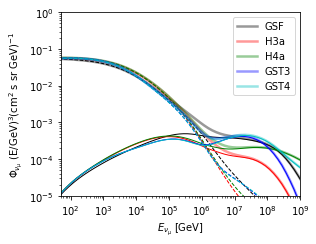

In [11]:
for pref, lab in [('numu_',r'\nu_\mu'), 
#                   ('mu_',r'\mu'), 
#                   ('nue_',r'\nu_e')
                 ]:
    plt.figure(figsize=(4.5, 3.5))
    for (flux, p_sname, p_name), col in zip(p_spectrum_flux,['k','r','g','b','c']):
        
        plt.loglog(e_grid, flux[pref + 'total'], color=col, ls='-', lw=2.5,
                  label=p_sname, alpha=0.4)
        plt.loglog(e_grid, flux[pref + 'conv'], color=col, ls='--', lw=1,
                   label='_nolabel_')
        plt.loglog(e_grid, flux[pref + 'pr'], color=col,ls='-', lw=1, 
                   label='_nolabel_')
    plt.xlim(50,1e9)
    plt.ylim(1e-5,1)
    plt.xlabel(r"$E_{{{0}}}$ [GeV]".format(lab))
    plt.ylabel(r"$\Phi_{" + lab + "}$ (E/GeV)$^{" + str(mag) +" }$" + 
               "(cm$^{2}$ s sr GeV)$^{-1}$")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(desktop,pref + 'flux.pdf'))

Save as in ASCII file for other types of processing
---------------------------------------------------

In [12]:
for (flux, p_sname, p_name) in p_spectrum_flux:
    np.savetxt(open(os.path.join(desktop, 'numu_flux_' + p_sname + '.txt'),'w'),
    zip(e_grid, 
        flux['mu_conv'],flux['mu_pr'],flux['mu_total'],
        flux['numu_conv'],flux['numu_pr'],flux['numu_total'],
        flux['nue_conv'],flux['nue_pr'],flux['nue_total'],
        flux['nutau_pr']),
    fmt='%6.5E',
    header=('lepton flux scaled with E**{0}. Order (E, mu_conv, mu_pr, mu_total, ' +
            'numu_conv, numu_pr, numu_total, nue_conv, nue_pr, nue_total, ' +
            'nutau_pr').format(mag)
    )